In [20]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [21]:

data = pd.read_csv("electronic_sales.csv")


In [22]:
sampled_data = data.sample(frac=0.05, random_state=42)

In [23]:

aggregated_data = sampled_data.groupby(['Customer ID', 'Product Type']).agg({
    'Quantity': 'sum',
    'Total Price': 'sum',
    'Add-on Total': 'sum'
}).reset_index()


customer_product_matrix = aggregated_data.pivot_table(
    index='Customer ID', 
    columns='Product Type', 
    values=['Quantity', 'Total Price', 'Add-on Total'], 
    aggfunc='sum', 
    fill_value=0
)


In [24]:
customer_product_matrix.columns = ['_'.join(col).strip() for col in customer_product_matrix.columns]



In [26]:
scaler = StandardScaler()
normalized_data = scaler.fit_transform(customer_product_matrix)



In [28]:
similarity_matrix = cosine_similarity(normalized_data)
customers = customer_product_matrix.index.tolist()

G = nx.Graph()
G.add_nodes_from(customers)



In [29]:

N = 10  
for i in range(len(similarity_matrix)):
    similarities = similarity_matrix[i]
    top_n_indices = np.argsort(similarities)[::-1][1:N+1]    
    for j in top_n_indices:
        if similarities[j] > 0:  
            G.add_edge(customers[i], customers[j], weight=similarities[j])


In [10]:
pip install python-louvain


     ---------------------------------------- 0.0/204.6 kB ? eta -:--:--
     -- ------------------------------------- 10.2/204.6 kB ? eta -:--:--
     --- --------------------------------- 20.5/204.6 kB 165.2 kB/s eta 0:00:02
     ------- ----------------------------- 41.0/204.6 kB 281.8 kB/s eta 0:00:01
     -------------- ---------------------- 81.9/204.6 kB 459.5 kB/s eta 0:00:01
     ---------------- -------------------- 92.2/204.6 kB 476.3 kB/s eta 0:00:01
     ---------------- -------------------- 92.2/204.6 kB 476.3 kB/s eta 0:00:01
     ------------------------------------ 204.6/204.6 kB 623.1 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9403 sha256=ac80a85d52d7595940f137a81f50ec5de5a4550ff66125e5a44d80a78ebc5e6b
  Stored in directory: c:\users\dell latitude 7490\appdata\local\pip\cache\wheels\11\c1\e7\f62a211c636275e2

In [30]:
import community as community_louvain 

partition = community_louvain.best_partition(G)

cluster_mapping = partition


In [31]:

sampled_data['Cluster'] = sampled_data['Customer ID'].map(cluster_mapping)


In [32]:

cluster_stats = sampled_data.groupby('Cluster').agg({
    'Total Price': ['mean', 'sum', 'median'],
    'Quantity': ['mean', 'sum', 'median'],
    'Add-on Total': ['mean', 'sum', 'median'],
    'Age': ['mean', 'median'],
    'Gender': lambda x: x.mode()[0] 
}).reset_index()


In [33]:

print("\nCluster Profiling (Statistics):")
print(cluster_stats)



Cluster Profiling (Statistics):
   Cluster  Total Price                       Quantity              \
                   mean        sum    median      mean  sum median   
0        0  6601.174423  343261.07  6838.080  6.634615  345    7.0   
1        1  2640.090714   36961.27  2359.230  3.357143   47    3.0   
2        2  2995.787561  122827.29  3247.720  6.414634  263    7.0   
3        3  2993.953023  128739.98  2697.280  4.744186  204    5.0   
4        4  1666.471940  111653.62   791.190  2.835821  190    3.0   
5        5  1529.476543  123887.60   786.410  3.000000  243    3.0   
6        6  2246.940667   67408.22  2167.080  6.166667  185    6.0   
7        7  1447.381754   82500.76  1348.640  2.491228  142    2.0   
8        8  2219.887368   84355.72  1838.000  4.657895  177    4.0   
9        9   210.839167    7590.21   166.000  7.277778  262    7.5   
10      10  4777.885217  219782.72  4679.920  7.804348  359    8.0   
11      11  5340.145000  192245.22  5504.870  6.805556  2

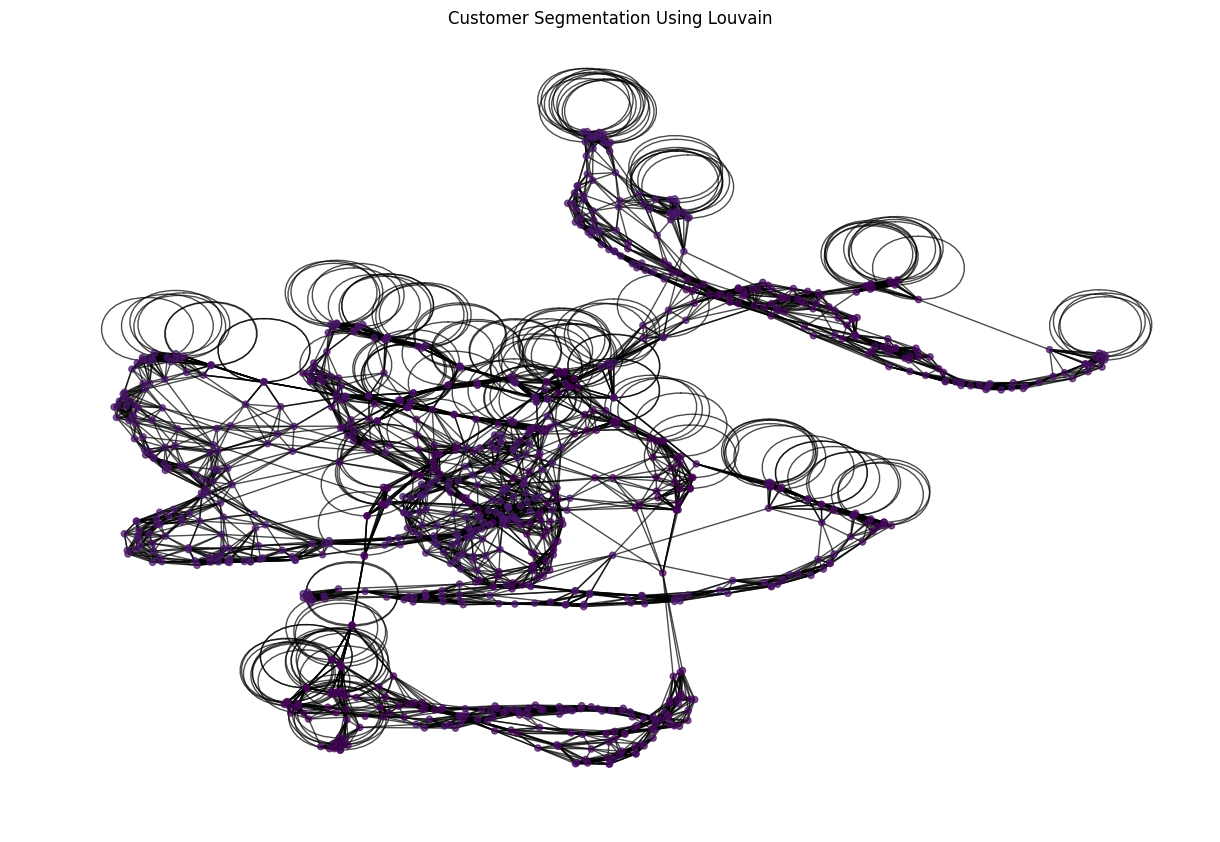

In [34]:

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
cmap = plt.get_cmap("viridis")
nx.draw(G, pos, node_color=[cmap(cluster_mapping[node]) for node in G.nodes()],
        with_labels=False, node_size=20, alpha=0.7)
plt.title("Customer Segmentation Using Louvain")
plt.show()


In [35]:

cluster_counts = pd.Series(cluster_mapping).value_counts()
print("Cluster Distribution:")
print(cluster_counts)


Cluster Distribution:
16    90
17    90
14    81
5     79
15    69
13    68
4     67
7     56
0     50
12    46
10    46
3     42
2     39
8     37
11    35
9     33
6     29
1     14
dtype: int64


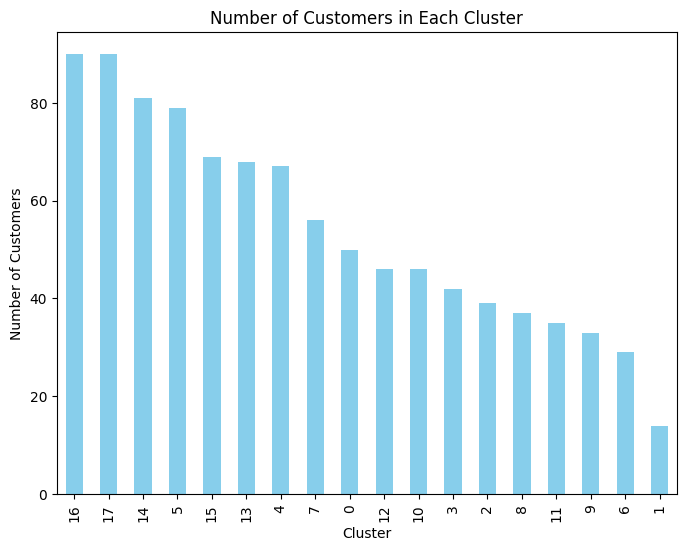

In [36]:

plt.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title("Number of Customers in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.show()


In [38]:
from sklearn.metrics import silhouette_score


In [40]:

silhouette_avg = silhouette_score(normalized_data, list(cluster_mapping.values()))

print(f"Silhouette Score: {silhouette_avg:.4f}")



Silhouette Score: 0.1813
